In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import numpy as np

w1 = np.arange(-10,10,0.05)
w2 = np.arange(-10,10,0.05)
w1, w2 = np.meshgrid(w1, w2)
lossfn = (2 - w1 - w2)**2 + (4 - 3*w1 - w2)**2

#定义一个绘制三维图像的函数
#elev表示上下旋转的角度
#azim表示平行旋转的角度

def plot_3D(elev=45,azim=60,X=w1,y=w2):
    fig, ax = plt.subplots(1, 1,constrained_layout=True, figsize=(8, 8))
    ax = plt.subplot(projection="3d")
    ax.plot_surface(w1, w2, lossfn, cmap='rainbow',alpha=0.7)
    ax.view_init(elev=elev,azim=azim)
    #ax.xticks([-10,-5,0,5,10])
    ax.set_xlabel("w1",fontsize=20)
    ax.set_ylabel("w2",fontsize=20)
    ax.set_zlabel("lossfn",fontsize=20)
    plt.show()

from ipywidgets import interact,fixed
interact(plot_3D,elev=[0,15,30],azip=(-180,180),X=fixed(w1),y=fixed(w2))
plt.show()

interactive(children=(Dropdown(description='elev', options=(0, 15, 30), value=0), IntSlider(value=60, descript…

在梯度下降的最初，我们需要先找出坐标点对应的梯度向量。梯度向量是各个自变量求偏导后的表达式
再带入坐标点计算出来的，在这一步骤中，最大的难点在于如何获得梯度向量的表达式——也就是损失
函数对各个自变量求偏导后的表达式。在单层神经网络，例如逻辑回归（二分类单层神经网络）中，我
们有如下计算：

## Pytorch 反向传播

In [2]:
import torch
x = torch.tensor(1,requires_grad=True, dtype=torch.float32)
z = x**2
y = torch.tensor(2,requires_grad=False, dtype=torch.float32)
sigma = torch.sigmoid(z) 
loss = -(y*torch.log(sigma) + (1-y)*torch.log(1-sigma))
torch.autograd.grad(loss,x)

(tensor(-2.5379),)

In [7]:
# 多个数量进行反向传播

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss as CEL
from torch.nn import functional as F

torch.manual_seed(420)
X = torch.rand((500,20),dtype=torch.float32) * 100
y = torch.randint(low=0,high=3,size=(500,),dtype=torch.float32)

In [8]:
input_ = X.shape[1]
output_ = len(y.unique())

class Model(nn.Module):
    def __init__(self,in_features=40,out_features=2):
        super().__init__()
        self.linear1 = nn.Linear(in_features,13,bias=False)
        self.linear2 = nn.Linear(13,8,bias=False)
        self.output = nn.Linear(8,out_features,bias=True)
    
    def forward(self, x):
        sigma1 = torch.relu(self.linear1(x))
        sigma2 = torch.sigmoid(self.linear2(sigma1))
        zhat = self.output(sigma2)
        return zhat

In [9]:
torch.manual_seed(420)
net = Model(in_features=input_, out_features=output_)
zhat = net.forward(X)
criterion = CEL()
loss = criterion(zhat, y.long())
loss

tensor(1.1559, grad_fn=<NllLossBackward0>)

In [10]:
net.linear1.weight.grad #还没有梯度

In [11]:
loss.backward(retain_graph=True) # 保存计算图可以多次反向传播，不保存只传播一次

In [12]:
net.linear1.weight.grad # 查看对应的梯度

tensor([[-3.0294e-04, -7.4869e-05, -3.6707e-04, -3.8675e-05, -1.3070e-04,
         -5.8467e-05, -3.3313e-04, -2.5863e-04, -9.4271e-05, -4.2617e-05,
         -7.9180e-05, -1.5179e-04, -9.2079e-05, -3.2513e-04, -1.0894e-04,
         -6.5035e-05, -1.3006e-04, -4.4115e-06, -9.6739e-05, -8.5471e-05],
        [ 1.0099e-02, -9.9189e-04,  1.2005e-02,  1.0410e-03,  5.1961e-03,
          3.5567e-03,  6.0618e-03,  3.9976e-03,  1.4981e-02,  9.0948e-03,
          6.0929e-03,  7.5188e-03,  1.3888e-02,  1.1927e-03,  8.9806e-03,
          9.8215e-03,  1.7637e-02,  1.0377e-02,  1.6778e-03,  7.8358e-04],
        [-1.0467e-02,  7.9738e-03,  3.0350e-03,  7.4985e-03,  4.3230e-03,
          9.8742e-04,  9.2578e-03,  6.3660e-03, -5.8071e-03,  1.1588e-03,
         -2.6623e-03,  6.3559e-03, -2.9338e-03, -4.4924e-03, -5.0406e-03,
          8.4390e-03, -1.0344e-02, -8.5044e-03,  2.1374e-03, -1.2447e-03],
        [-1.3464e-02, -1.0530e-02, -8.3316e-03, -1.5648e-02, -1.2376e-02,
         -1.6419e-02, -9.7809e-03, 

w(t+1) = w(t) - 步长 * grad

## SGD

In [15]:
net.linear1.weight.data #返回相应的权重值

tensor([[ 1.3656e-01, -1.3459e-01,  2.1281e-01, -1.7763e-01, -6.8218e-02,
         -1.5410e-01,  1.7245e-01,  8.3885e-02, -1.1153e-01, -1.7294e-01,
         -1.2947e-01, -4.3138e-02, -1.1413e-01,  1.6295e-01, -9.4082e-02,
         -1.4629e-01, -6.8982e-02, -2.1836e-01, -1.0859e-01, -1.2199e-01],
        [ 4.8127e-02,  1.8186e-01,  2.4149e-02, -1.3032e-01,  9.2056e-02,
         -9.5202e-02, -1.0584e-01, -4.2852e-02, -1.1669e-01,  2.4581e-02,
          1.8152e-01,  3.0500e-02,  1.3506e-01, -1.9425e-01, -1.7591e-01,
         -2.9751e-02,  2.0485e-04,  1.3957e-01, -1.9666e-01,  9.3293e-02],
        [-1.9192e-01,  3.6070e-02,  1.4778e-01,  3.0845e-02,  7.1393e-02,
          1.4217e-01,  2.2122e-01, -1.4032e-01,  7.3255e-02,  1.8409e-01,
          1.2716e-01, -2.0253e-01, -1.5509e-01, -2.1899e-01,  9.8980e-02,
          2.2123e-01, -2.1659e-01,  1.7880e-01, -2.0922e-01, -2.7275e-02],
        [ 1.8144e-01, -3.5166e-02,  2.4801e-02,  1.6299e-01, -1.8755e-01,
          5.6587e-02, -1.0911e-01, 

In [16]:
lr = 10 #learning_rate, 0.001,0.01,0.05

In [ ]:
w = net.linear1.weight.data #现有的权重，w(t)
dw = net.linear1.weight.grad

In [20]:
w -= lr*dw
w

tensor([[ 1.4868e-01, -1.3160e-01,  2.2749e-01, -1.7608e-01, -6.2990e-02,
         -1.5176e-01,  1.8578e-01,  9.4230e-02, -1.0776e-01, -1.7123e-01,
         -1.2630e-01, -3.7066e-02, -1.1045e-01,  1.7595e-01, -8.9725e-02,
         -1.4368e-01, -6.3780e-02, -2.1819e-01, -1.0472e-01, -1.1857e-01],
        [-3.5582e-01,  2.2153e-01, -4.5607e-01, -1.7196e-01, -1.1579e-01,
         -2.3747e-01, -3.4831e-01, -2.0276e-01, -7.1593e-01, -3.3921e-01,
         -6.2197e-02, -2.7025e-01, -4.2048e-01, -2.4196e-01, -5.3514e-01,
         -4.2261e-01, -7.0528e-01, -2.7552e-01, -2.6377e-01,  6.1950e-02],
        [ 2.2677e-01, -2.8288e-01,  2.6378e-02, -2.6910e-01, -1.0153e-01,
          1.0267e-01, -1.4909e-01, -3.9496e-01,  3.0554e-01,  1.3774e-01,
          2.3365e-01, -4.5676e-01, -3.7733e-02, -3.9295e-02,  3.0061e-01,
         -1.1633e-01,  1.9717e-01,  5.1898e-01, -2.9471e-01,  2.2513e-02],
        [ 7.2001e-01,  3.8603e-01,  3.5807e-01,  7.8890e-01,  3.0748e-01,
          7.1337e-01,  2.8213e-01, 

# Adam

普通梯度下降就是在重复正向传播、计算梯度、更新权重的过程，但这个过程往往非常漫长。如大家所
见，步长设置为0.001时，我们看不到w任何的变化，只有当步长设置得非常巨大，我们才能够看到一些
改变，但在之前的课程中我们说过，巨大的步长可能会让我们跳过真正的最小值，所以我们无法将步长
设置得很大，无论如何，梯度下降都是一个缓慢的过程。在这个基础上，我们提出了加速迭代的数个方
法，其中一个很关键的方法，就是使用动量Momentum。

之前我们说过，在梯度下降过程中，起始点是一个“盲人”，它看不到也听不到全局，所以我们每移动一
次都要重新计算方向与距离，并且每次只能走一小步。但不只限于此，起始点不仅看不到前面的路，也
无法从过去走的路中学习。
想象一下，我们被蒙上眼睛，由另一个人喊口号来给与我们方向让我们移动，假设喊口号的人一直喊：”
向前，向前，向前。“因为我们看不见，在最初的三四次，我们可能都只会向前走一小步，但如果他一直
让我们向前，我们就会失去耐心，转而向前走一大步，因为我们可以预测：前面很长一段路大概都是需
要向前的。对梯度下降来说，也是同样的道理——如果在很长一段时间内，起始点一直向相似的方向移
动，那按照步长一小步一小步地磨着向前是没有意义的，既浪费计算资源又浪费时间，此时就应该大但
地照着这个方向走一大步。相对的，如果我们很长时间都走向同一个方向，突然让我们转向，那我们转
向的第一步就应该非常谨慎，走一小步。
不难发现，真正高效的方法是：在历史方向与现有方向相同的情况下，迈出大步子，在历史方向与现有
方向相反的情况下，迈出小步子。那要怎么才能让起始点了解过去的方向呢？我们让上一步的梯度向量
与现在这一点的梯度向量以加权的方式求和，求解出受到上一步大小和方向影响的真实下降方向，再让
坐标点向真实下降方向移动。在坐标轴上，可以表示为

In [22]:
#恢复小步长
lr = 0.1
gamma = 0.9
dw = net.linear1.weight.grad
w = net.linear1.weight.data
v = torch.zeros(dw.shape[0],dw.shape[1])
#v要能够跟dw相减，因此必须和dw保持相同的结构，初始v为0，但后续v会越来越大

In [23]:
v = gamma * v - lr * dw # 保持和梯度减同方向了
w += v

# 整体流程 

In [1]:
##导入库
#确定数据、超参数的确定（lr，gamma）
#定义伸进网络的架构类Model，类Model需要输入的参数
##实例化神经网络的类 - 让神经网络准备好进行正向传播
#定义损失函数
#定义优化算法

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

In [2]:
torch.manual_seed(420)
X = torch.rand((500,20),dtype=torch.float32) * 100
y = torch.randint(low=0,high=3,size=(500,),dtype=torch.float32)

In [3]:
lr = 0.1
gamma = 0.9
class Model(nn.Module):
    def __init__(self,in_features=10,out_features=2):
        super(Model,self).__init__() #super(请查找这个类的父类，请使用找到的父类替换现在的类)
        self.linear1 = nn.Linear(in_features,13,bias=True) #输入层不用写，这里是隐藏层的第一层
        self.linear2 = nn.Linear(13,8,bias=True)
        self.output = nn.Linear(8,out_features,bias=True)
        
    def forward(self, x):
        sigma1 = torch.relu(self.linear1(x))
        sigma2 = torch.sigmoid(self.linear2(sigma1))
        zhat = self.output(sigma2)
        return zhat

In [4]:
input_ = X.shape[1] #特征的数目
output_ = len(y.unique()) #分类的数目

In [5]:
#实例化神经网络类
torch.manual_seed(420)
net = Model(in_features=input_, out_features=output_)

In [6]:
for x in net.parameters():
    print(x)

Parameter containing:
tensor([[ 1.3656e-01, -1.3459e-01,  2.1281e-01, -1.7763e-01, -6.8218e-02,
         -1.5410e-01,  1.7245e-01,  8.3885e-02, -1.1153e-01, -1.7294e-01,
         -1.2947e-01, -4.3138e-02, -1.1413e-01,  1.6295e-01, -9.4082e-02,
         -1.4629e-01, -6.8982e-02, -2.1836e-01, -1.0859e-01, -1.2199e-01],
        [ 4.8127e-02,  1.8186e-01,  2.4149e-02, -1.3032e-01,  9.2056e-02,
         -9.5202e-02, -1.0584e-01, -4.2852e-02, -1.1669e-01,  2.4581e-02,
          1.8152e-01,  3.0500e-02,  1.3506e-01, -1.9425e-01, -1.7591e-01,
         -2.9751e-02,  2.0485e-04,  1.3957e-01, -1.9666e-01,  9.3293e-02],
        [-1.9192e-01,  3.6070e-02,  1.4778e-01,  3.0845e-02,  7.1393e-02,
          1.4217e-01,  2.2122e-01, -1.4032e-01,  7.3255e-02,  1.8409e-01,
          1.2716e-01, -2.0253e-01, -1.5509e-01, -2.1899e-01,  9.8980e-02,
          2.2123e-01, -2.1659e-01,  1.7880e-01, -2.0922e-01, -2.7275e-02],
        [ 1.8144e-01, -3.5166e-02,  2.4801e-02,  1.6299e-01, -1.8755e-01,
          5.6

In [7]:
#定义损失函数
criterion = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters()#需要进行迭代的权重
                ,lr = lr
                ,momentum = gamma
               )

In [8]:
zhat = net.forward(X) #最后一个线性层的输出结果，向前传播
loss = criterion(zhat, y.reshape(500).long()) #计算损失函数
loss.backward()
opt.step() #步子，走一步，更新权重w，更新动量v
opt.zero_grad()

print(loss)
print(net.linear1.weight.data[0][:10])

tensor(1.1057, grad_fn=<NllLossBackward0>)
tensor([ 0.1365, -0.1346,  0.2128, -0.1776, -0.0682, -0.1541,  0.1724,  0.0839,
        -0.1115, -0.1729])


In [ ]:
for epochs in range(epoch):
    for batch in range(batch):
        zhat = net.forward(X) #最后一个线性层的输出结果，向前传播
        loss = criterion(zhat, y.reshape(500).long()) #计算损失函数
        loss.backward()
        opt.step() #步子，走一步，更新权重w，更新动量v
        opt.zero_grad()

## batch

小批量，每一次变化更大，更有可能全局最优。
缺点：需要迭代的次数可能更多。

### 导入数据TensorDataset，DataLoader

In [10]:
from torch.utils.data import TensorDataset

In [11]:
# 500代表样本个数
a = torch.randn(500,2,3) #三维数据 - 二维表格
b = torch.randn(500,3,4,5) #四维数据 - 图像
c = torch.randn(500,1) #二维数据 - 标签

In [12]:
data = TensorDataset(a, b, c)

In [13]:
for x in TensorDataset(b,c):#generator
    print(x) # b对应4,5
    break

(tensor([[[ 0.3641,  1.1461,  1.3315, -0.6803, -0.1573],
         [-0.3813,  0.0569,  1.4741, -0.2237,  0.4374],
         [ 0.4338,  0.7315, -0.2749,  0.0160, -0.2451],
         [-0.5867, -0.5889,  1.8905, -0.7718, -1.7899]],

        [[-0.4048,  0.7898,  0.3773,  0.7166,  0.0490],
         [-0.9121, -0.0489, -0.8179, -1.8548, -0.3418],
         [ 0.0873,  0.3071, -0.9272,  1.4546, -0.8360],
         [ 1.2235,  1.2197, -0.5222,  0.2297, -0.8180]],

        [[ 0.4578, -2.0396, -0.1589, -0.3033, -0.6102],
         [ 1.1299,  0.8919, -0.5627,  0.4364, -0.2321],
         [ 0.1634,  1.4667, -0.7651, -0.6503,  0.0228],
         [ 0.8123,  0.9057,  1.3573, -0.3826,  0.2580]]]), tensor([-0.4762]))


In [ ]:
# dataloader用来切割小批量
DataLoader(data)


In [ ]:
dataset = DataLoader(data
          , batch_size = 24
          , shuffle = True #划分小批量之前请随机打乱我们的数据
          , drop_last = True #你要舍弃最后一个batch吗？
          )

In [ ]:
len(dataset) #一共有多少个batch
len(dataset.dataset) #展示里面全部的数据

In [ ]:
dataset.dataset[0] #单个样本
dataset.batch_size #查看现有的batch_size

## 在MINST-FASHION上实现神经网络的学习流程

In [14]:
import torchvision
import torchvision.transforms as transforms #处理数据模块
#dataloader、TensorDataset - 对数据的结构、归纳方式进行变换
#torchvision.transforms - 对数据集的数字本身进行修改

In [16]:
mnist = torchvision.datasets.FashionMNIST(root = "./" #你的计算机上的某个目录
                                          ,download = True
                                          , train = True
                                          , transform = transforms.ToTensor()
                                         ) #实例化数据

In [17]:
mnist #对于数据的一个说明

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()

In [18]:
mnist.data.shape #特征张量

torch.Size([60000, 28, 28])

In [19]:
mnist.targets.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [20]:
mnist.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

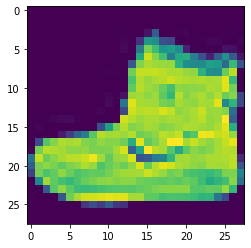

In [21]:
import matplotlib.pyplot as plt
import numpy
plt.imshow(mnist[0][0].view(28,28).numpy()); #imageshow

### 训练

In [29]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms 

#确定数据、确定超参数

lr = 0.15
gamma = 0
epochs = 3
bs = 128

mnist = torchvision.datasets.FashionMNIST(root = "./" #你的计算机上的某个目录
                                          ,download = False
                                          , train = True
                                          , transform = transforms.ToTensor()
                                         )

In [30]:
batchdata = DataLoader(mnist
                       ,batch_size = bs
                       ,shuffle = True)
for x,y in batchdata:
    print(x.shape)
    print(y.shape)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [31]:
input_ = mnist.data[0].numel() #28*28
output_ = len(mnist.targets.unique()) # 10

In [37]:
class Model(nn.Module):
    def __init__(self, in_features=10, out_features=2):
        super().__init__()
        self.normalize = nn.BatchNorm2d(num_features=1)
        self.linear1 = nn.Linear(in_features,1280,bias=False)
        self.output = nn.Linear(1280,out_features, bias=False)
    
    def forward(self, x):
        x = self.normalize(x)
        x = x.view(-1,28*28)
        sigma1 = torch.relu(self.linear1(x))
#         sigma1 = self.normalize(sigma1)
        sigma2 = F.log_softmax(self.output(sigma1),dim=1)
        return sigma2

In [38]:
def fit(net,bacthdata,lr=0.01, epochs=5, gamma = 0):
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(),lr=lr,momentum = gamma)
    correct = 0 #循环开始之前，预测正确的值为0
    samples = 0 #循环开始之前，模型一个样本都没有见过
    for epoch in range(epochs): #全数据被训练几次
        for batch_idx,(x,y) in enumerate(batchdata):
            y = y.view(x.shape[0]) #降维
            sigma = net.forward(x) #正向传播
            loss = criterion(sigma,y)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            #求解准确率，全部判断正确的样本数量/已经看过的总样本量
            yhat = torch.max(sigma, 1)[1] #torch.max函数结果中的索引为1的部分
            correct += torch.sum(yhat == y)
            samples += x.shape[0]
            #每训练一个batch的数据，模型见过的数据就会增加x.shape[0]
            
            if (batch_idx + 1) % 125 == 0 or batch_idx == len(batchdata)-1: #每N个batch我就打印一次
                print("Epoch{}:[{}/{}({:.0f}%)],Loss:{:.6f},Accuracy:{:.3f}".format(
                    epoch+1
                    ,samples
                    ,epochs*len(batchdata.dataset)
                    ,100*samples/(epochs*len(batchdata.dataset))
                    ,loss.data.item()
                    ,float(100*correct/samples)
                     ))
            #分子代表：已经查看过的数据有多少
            #分母代表：在现有的epochs设置，模型一共需要查看多少数据

In [39]:
torch.manual_seed(420)
net = Model(in_features=input_, out_features=output_)
fit(net,batchdata,lr=lr,epochs=epochs,gamma=gamma)

ValueError: expected 4D input (got 2D input)